In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 4th Down, Go vs Punt Logic Exploration
This notebook will define logic for 4th down decisions based on the following:
- Yards to go
- Field Position
- Historical Success Rates and EPA

I will use the cleaned df_4th dataframe that is filtered to 4th down plays only


In [ ]:
df_4th = pd.read_csv("C:/Users/jseidl/NFL-4th-Down/data/processed/cleaned_4th_down.csv")

In [5]:
df_4th.head()

,game_id,play_id,season,week,game_date,qtr,posteam,defteam,down,ydstogo,...,wpa,field_goal_result,kick_distance,punt_blocked,no_huddle,shotgun,qb_dropback,desc,yard_bin,go_success
0,2010_01_ARI_STL,350.0,2010,1,2010-09-12,1.0,LA,ARI,4.0,7.0,...,-0.125491,blocked,34.0,0.0,0.0,0.0,0.0,(9:41) 3-Josh.Brown 34 yard field goal is BLOC...,"(10, 20]",False
1,2010_01_ARI_STL,445.0,2010,1,2010-09-12,1.0,ARI,LA,4.0,10.0,...,0.028613,NaN,46.0,0.0,0.0,0.0,0.0,"(8:12) 5-B.Graham punts 46 yards to LA 11, Cen...","(50, 60]",False
2,2010_01_ARI_STL,644.0,2010,1,2010-09-12,1.0,ARI,LA,4.0,10.0,...,-0.025066,NaN,29.0,0.0,0.0,0.0,0.0,"(4:57) 5-B.Graham punts 29 yards to LA 10, Cen...","(30, 40]",False
3,2010_01_ARI_STL,727.0,2010,1,2010-09-12,1.0,LA,ARI,4.0,3.0,...,-0.014153,NaN,50.0,0.0,0.0,0.0,0.0,"(3:06) 5-D.Jones punts 50 yards to ARI 33, Cen...","(80, 90]",False
4,2010_01_ARI_STL,1018.0,2010,1,2010-09-12,2.0,ARI,LA,4.0,3.0,...,-0.039393,made,22.0,0.0,0.0,0.0,0.0,"(13:57) 4-J.Feely 22 yard field goal is GOOD, ...","(0, 10]",False


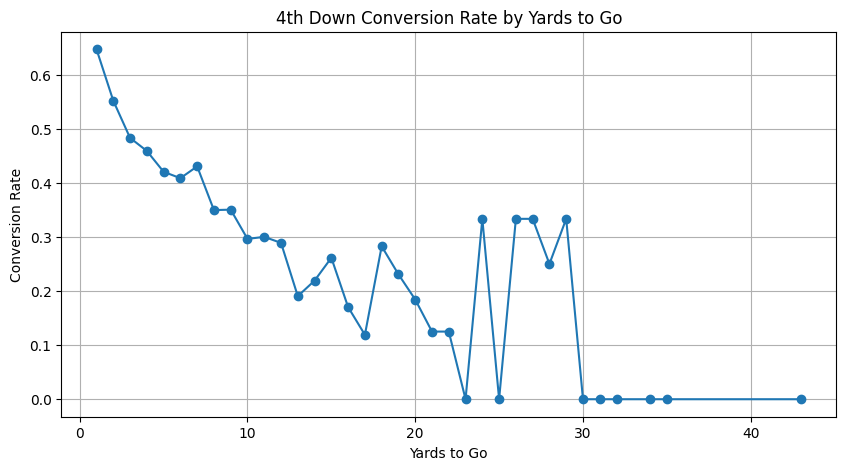

In [6]:
# Copied from eda ipynb notebook file and tweaked
# Only plays where team goes for it on 4th / is a run or pass 
conversion_attemps = df_4th[df_4th["play_type"].isin(["run", "pass"])]

# Clean and Sort
conversion_rate = (
    conversion_attemps.groupby("ydstogo")["success"]
    .mean()
    .reset_index()
    .sort_values("ydstogo")
)

# Casting yds to go as integer
conversion_rate["ydstogo"] = conversion_rate["ydstogo"].astype(int)

# Plot with matplotlib to visualize and explore
plt.figure(figsize=(10, 5))
plt.plot(conversion_rate["ydstogo"], conversion_rate["success"], marker="o")
plt.title("4th Down Conversion Rate by Yards to Go")
plt.xlabel("Yards to Go")
plt.ylabel("Conversion Rate")
plt.grid(True)
plt.show()

In [10]:
# Separating Go and Punt Attempts
df_go = df_4th[df_4th["play_type"].isin(["run", "pass"])].copy()
df_punt = df_4th[df_4th["play_type"] == "punt"].copy()

In [11]:
# Binning yardlines into 10 yard bins
df_go["yard_bin"] = pd.cut(df_go["yardline_100"], bins=range(0, 110, 10))
df_punt["yard_bin"] = pd.cut(df_punt["yardline_100"], bins=range(0, 110, 10))

In [15]:
# EPA Grouping by Yard bin
epa_go = df_go.groupby("yard_bin")["epa"].mean()
epa_punt = df_go.groupby("yard_bin")["epa"].mean()

In [16]:
epa_compare = pd.DataFrame({"Go Epa": epa_go, "Punt EPA": epa_punt})

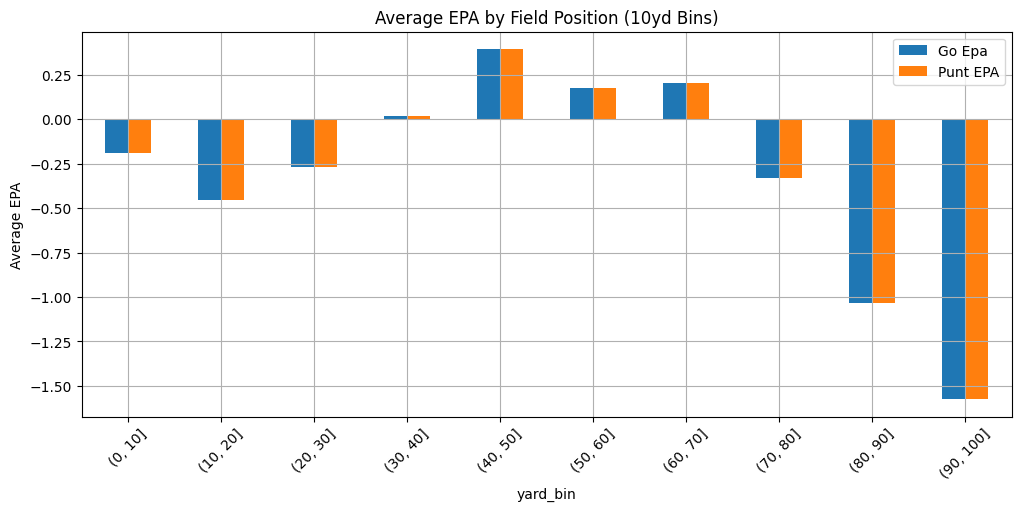

In [17]:
epa_compare.plot(kind="bar", figsize=(12,5))
plt.title("Average EPA by Field Position (10yd Bins)")
plt.ylabel("Average EPA")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [18]:
# First iteration rule creation
def decision(ydstogo, yardline_100):
    if ydstogo <= 2 and yardline_100 <= 50:
        return "Go"
    elif ydstogo <= 4 and yardline_100 <= 40:
        return "Go"
    else:
        return "Punt"

In [19]:
decision(10, 25)

'Punt'

In [20]:
decision(2, 25)

'Go'

In [21]:
decision(1, 60)

'Punt'

In [27]:
# Second attempt logic creation
df_go["yard_bin"] = pd.cut(df_go["yardline_100"], bins=range(0, 110, 10))
df_go["distance_bin"] = pd.cut(df_go["ydstogo"], bins=[0, 1, 2, 4, 6, 10, 100])

In [28]:
# Creating a conversion table for decision making zones
conversion_table = (
    df_go[df_go["play_type"].isin(["run", "pass"])]
    .groupby(["yard_bin", "distance_bin"])
    .agg(success_rate=("success", "mean"), avg_epa=("epa", "mean"), attempts=("play_type", "count"))
    .reset_index()
)

conversion_table.head()

,yard_bin,distance_bin,success_rate,avg_epa,attempts
0,"(0, 10]","(0, 1]",0.570000,-0.172940,700
1,"(0, 10]","(1, 2]",0.497487,0.332592,199
2,"(0, 10]","(2, 4]",0.366667,-0.387526,180
3,"(0, 10]","(4, 6]",0.282609,-0.837918,92
4,"(0, 10]","(6, 10]",0.310345,-0.547586,58


In [29]:
def lookup_table_row(ydstogo, yardline_100, table):
    for _, row in table.iterrows():
        if row["yard_bin"].left <= yardline_100 < row["yard_bin"].right and row["distance_bin"].left <= ydstogo < row["distance_bin"].right:
            return row
    return None

In [41]:
def decide_go_punt(ydstogo, yardline_100, table):
    row = lookup_table_row(ydstogo, yardline_100, table)
    if row is None:
        return "No Go"
    if row["avg_epa"] > 0 and row["attempts"] >= 50:
        return "Go"
    else:
        return "No Go"

In [49]:
decision = decide_go_punt(1, 80, conversion_table)
print(decision)

No Go


In [50]:
df_go["go_success"] = df_go["success"] == 1

In [59]:
# Estimating success / Failure EPA
epa_split = (
    df_go.groupby(["yard_bin", "distance_bin", "go_success"]).agg(avg_epa=("epa", "mean"), count=("epa", "count")).reset_index())

epa_pivot = epa_split.pivot_table(index=["yard_bin", "distance_bin"], columns="go_success", values="avg_epa").reset_index()

epa_pivot.columns.name = None
epa_pivot.rename(columns={False: "epa_fail", True: "epa_success"}, inplace=True)

In [60]:
# Merging conversion rates
conversion_table = (
    df_go.groupby(["yard_bin", "distance_bin"])
    .agg(success_rate=("success", "mean"), attempts=("play_type", "count"))
    .reset_index()
)

decision_table = pd.merge(conversion_table, epa_pivot, on=["yard_bin", "distance_bin"])

In [61]:
# No Go EPA Estimates
df_punt = df_4th[df_4th["play_type"] == "punt"].copy()
df_punt["yard_bin"] = pd.cut(df_punt["yardline_100"], bins=range(0, 110, 10))

punt_epa_table = (
    df_punt.groupby("yard_bin")["epa"]
    .mean()
    .reset_index()
    .rename(columns={"epa": "epa_punt"})
)

decision_table = pd.merge(decision_table, punt_epa_table, on="yard_bin", how="left")

In [83]:
# Building decision table to determine expected value
decision_table["ev_go"] = (
    decision_table["success_rate"] * decision_table["epa_success"]
    + (1 - decision_table["success_rate"]) * decision_table["epa_fail"]
)

decision_table["better_choice"] = decision_table["ev_go"] > decision_table["epa_punt"]
decision_table["decision"] = decision_table["better_choice"].map({True: "Go", False: "No Go"})

In [84]:
# Decision Function
def decide_ev_based(ydstogo, yardline_100, table):
    for _, row in table.iterrows():
        if row["yard_bin"].left <= yardline_100 < row["yard_bin"].right and \
           row["distance_bin"].left <= ydstogo < row["distance_bin"].right:
            return row["decision"]
    return "No Go"

In [85]:
# Testing the decisions
test_decision = decide_ev_based(ydstogo=3, yardline_100=55, table=decision_table)
print(f"Decision: {test_decision}")

Decision: No Go


In [86]:
print(decide_ev_based(1, 25, decision_table))

Go


In [87]:
print(decide_ev_based(7, 1, decision_table))

No Go


In [88]:
print(decide_ev_based(1, 90, decision_table))

No Go


In [ ]:
decision_table.to_csv("C:/Users/jseidl/NFL-4th-Down/data/processed/decision_table.csv",index=False)